# How much do Covariates Matter?

## Motivation

In regression analyses, we often wonder about "how much covariates matter?" for explaining the relationship between a target variable $D$ and an outcome variable $Y$. 

For example, we might start analysing the gender wage gap with a simple regression model as `log(wage) on gender`. But arguably, men and women differ in many socio-economic characteristics: they might have different (average) levels of education or career experience, and they might work in different industries and select into different higher- or lower-paying industries. So which fraction of the gender wage gap can be explained by these observable characteristics? 

In this notebook, we will compute and decompose the gender wage gab based on a subset of the PSID data set using a method commonly known as the 
"Gelbach Decomposition" ([Gelbach, JoLE 2016](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1425737)). 

We start with loading a subset of the PSID data provided by the AER R package. 

In [1]:
import re

import pandas as pd

import pyfixest as pf

psid = pd.read_csv(
    "https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/refs/heads/master/csv/AER/PSID7682.csv"
)
psid["experience"] = pd.Categorical(psid["experience"])
psid["year"] = pd.Categorical(psid["year"])
psid.head()

,rownames,experience,weeks,occupation,industry,south,smsa,married,gender,union,education,ethnicity,wage,year,id
0,1,3,32,white,no,yes,no,yes,male,no,9,other,260,1976,1
1,2,4,43,white,no,yes,no,yes,male,no,9,other,305,1977,1
2,3,5,40,white,no,yes,no,yes,male,no,9,other,402,1978,1
3,4,6,39,white,no,yes,no,yes,male,no,9,other,402,1979,1
4,5,7,42,white,yes,yes,no,yes,male,no,9,other,429,1980,1


Computing a first correlation between gender and wage, we find that males earn on average 0.474 log points
more than women. 

In [2]:
fit_base = pf.feols("log(wage) ~ gender", data=psid, vcov="hetero")
fit_base.summary()

###

Estimation:  OLS
Dep. var.: log(wage), Fixed effects: 0
Inference:  hetero
Observations:  4165

| Coefficient    |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:---------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept      |      6.255 |        0.020 |   320.714 |      0.000 |  6.217 |   6.294 |
| gender[T.male] |      0.474 |        0.021 |    22.818 |      0.000 |  0.434 |   0.515 |
---
RMSE: 0.436 R2: 0.106 


To examine the impact of observable on the relationship between wage and gender, a common strategy in applied research is to incrementally add a set of covariates to the baseline regression model of `log(wage) on gender`. Here, we will incrementally add the following covariates:  

- education,
- experience
- occupation, 
- industry 
- year 
- ethnicity

We can do so by using **multiple estimation syntax**: 

In [3]:
fit_stepwise1 = pf.feols(
    "log(wage) ~ gender + csw0(education, experience, occupation, industry, year, ethnicity)",
    data=psid,
)
pf.etable(fit_stepwise1)

GT(_tbl_data=   level_0             level_1                      0                      1  \
0     coef      gender[T.male]  0.474*** <br> (0.021)  0.474*** <br> (0.019)   
1     coef           education                         0.065*** <br> (0.002)   
2     coef     experience[T.2]                                                 
3     coef     experience[T.3]                                                 
4     coef     experience[T.4]                                                 
..     ...                 ...                    ...                    ...   
61    coef           Intercept  6.255*** <br> (0.020)  5.419*** <br> (0.034)   
62   stats        Observations                   4165                   4165   
63   stats           S.E. type                    iid                    iid   
64   stats       R<sup>2</sup>                  0.106                  0.260   
65   stats  Adj. R<sup>2</sup>                  0.105                  0.260   

                        2                      3                      4  \
0   0.425*** <br> (0.018)  0.444*** <br> (0.018)  0.428*** <br> (0.018)   
1   0.075*** <br> (0.002)  0.061*** <br> (0.003)  0.063*** <br> (0.003)   
2      0.147 <br> (0.156)     0.156 <br> (0.155)     0.158 <br> (0.154)   
3      0.273 <br> (0.139)    0.284* <br> (0.138)    0.278* <br> (0.138)   
4    0.377** <br> (0.137)   0.389** <br> (0.136)   0.385** <br> (0.135)   
..                    ...                    ...                    ...   
61  4.566*** <br> (0.134)  4.664*** <br> (0.133)  4.636*** <br> (0.133)   
62                   4165                   4165                   4165   
63                    iid                    iid                    iid   
64                  0.376                  0.387                  0.391   
65                  0.368                  0.379                  0.383   

                        5                      6  
0   0.432*** <br> (0.016)  0.410*** <br> (0.017)  
1   0.060*** <br> (0.002)  0.059*** <br> (0.002)  
2      0.124 <br> (0.137)     0.128 <br> (0.136)  
3      0.232 <br> (0.122)    0.241* <br> (0.122)  
4     0.287* <br> (0.121)    0.298* <br> (0.120)  
..                    ...                    ...  
61  4.672*** <br> (0.118)  4.570*** <br> (0.118)  
62                   4165                   4165  
63                    iid                    iid  
64                  0.520                  0.525  
65                  0.513                  0.518  

[66 rows x 9 columns], _body=<great_tables._gt_data.Body object at 0x00000242B838F770>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None), ColInfo(var='3', type=<ColInfoTypeEnum.default: 1>, column_label='(4)', column_align='center', column_width=None), ColInfo(var='4', type=<ColInfoTypeEnum.default: 1>, column_label='(5)', column_align='center', column_width=None), ColInfo(var='5', type=<ColInfoTypeEnum.default: 1>, column_label='(6)', column_align='center', column_width=None), ColInfo(var='6', type=<ColInfoTypeEnum.default: 1>, column_label='(7)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x00000242B80BD2B0>, _spanners=Spanners([SpannerInfo(spanner_id='log(wage)', spanner_level=1, spanner_label='log(wage)', spanner_units=None, spanner_pattern=None, vars=['0', '1', '2', '3', '4', '5', '6'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_n

Because the table is so long that it's hard to see anything, we restrict it to display only a few variables: 

In [4]:
pf.etable(fit_stepwise1, keep=["gender", "ethnicity", "education"])

GT(_tbl_data=  level_0             level_1                      0                      1  \
0    coef      gender[T.male]  0.474*** <br> (0.021)  0.474*** <br> (0.019)   
1    coef  ethnicity[T.other]                                                 
2    coef           education                         0.065*** <br> (0.002)   
3   stats        Observations                   4165                   4165   
4   stats           S.E. type                    iid                    iid   
5   stats       R<sup>2</sup>                  0.106                  0.260   
6   stats  Adj. R<sup>2</sup>                  0.105                  0.260   

                       2                      3                      4  \
0  0.425*** <br> (0.018)  0.444*** <br> (0.018)  0.428*** <br> (0.018)   
1                                                                        
2  0.075*** <br> (0.002)  0.061*** <br> (0.003)  0.063*** <br> (0.003)   
3                   4165                   4165                   4165   
4                    iid                    iid                    iid   
5                  0.376                  0.387                  0.391   
6                  0.368                  0.379                  0.383   

                       5                      6  
0  0.432*** <br> (0.016)  0.410*** <br> (0.017)  
1                         0.133*** <br> (0.020)  
2  0.060*** <br> (0.002)  0.059*** <br> (0.002)  
3                   4165                   4165  
4                    iid                    iid  
5                  0.520                  0.525  
6                  0.513                  0.518  , _body=<great_tables._gt_data.Body object at 0x00000242B8167440>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None), ColInfo(var='3', type=<ColInfoTypeEnum.default: 1>, column_label='(4)', column_align='center', column_width=None), ColInfo(var='4', type=<ColInfoTypeEnum.default: 1>, column_label='(5)', column_align='center', column_width=None), ColInfo(var='5', type=<ColInfoTypeEnum.default: 1>, column_label='(6)', column_align='center', column_width=None), ColInfo(var='6', type=<ColInfoTypeEnum.default: 1>, column_label='(7)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x00000242B82DA3C0>, _spanners=Spanners([SpannerInfo(spanner_id='log(wage)', spanner_level=1, spanner_label='log(wage)', spanner_units=None, spanner_pattern=None, vars=['0', '1', '2', '3', '4', '5', '6'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x00000242B82DA8D0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_a

We see that the coefficient on gender is roughly the same in all models. Tentatively, we might already conclude that the observable characteristics in the data do not explain a large part of the gender wage gap. 

But how much do differences in education matter? We have computed 6 additional models that contain education as a covariate. The obtained point estimates 
vary between $0.059$ and $0.075$. Which of these numbers should we report?  

Additionally, note that while we have only computed 6 additional models with covariates, the number of possible models is much larger. 
If I did the math correctly, simply by additively and incrementally adding covariates, we could have computed $57$ different models (not all of which would have included `education` as a control).

As it turns out, different models **will lead to different point estimates**. The order of incrementally adding covariates **might** impact our conclusion. To illustrate this, we keep the same ordering as before, but start with `ethnicity` as our first variable: 

In [5]:
fit_stepwise2 = pf.feols(
    "log(wage) ~ gender + csw0(ethnicity, education, experience, occupation, industry, year)",
    data=psid,
)
pf.etable(fit_stepwise2, keep=["gender", "ethnicity", "education"])

GT(_tbl_data=  level_0             level_1                      0                      1  \
0    coef      gender[T.male]  0.474*** <br> (0.021)  0.436*** <br> (0.022)   
1    coef  ethnicity[T.other]                         0.227*** <br> (0.026)   
2    coef           education                                                 
3   stats        Observations                   4165                   4165   
4   stats           S.E. type                    iid                    iid   
5   stats       R<sup>2</sup>                  0.106                  0.121   
6   stats  Adj. R<sup>2</sup>                  0.105                  0.121   

                       2                      3                      4  \
0  0.450*** <br> (0.020)  0.399*** <br> (0.019)  0.418*** <br> (0.019)   
1  0.141*** <br> (0.024)  0.158*** <br> (0.023)  0.151*** <br> (0.022)   
2  0.064*** <br> (0.002)  0.074*** <br> (0.002)  0.060*** <br> (0.003)   
3                   4165                   4165                   4165   
4                    iid                    iid                    iid   
5                  0.266                  0.383                  0.394   
6                  0.266                  0.375                  0.386   

                       5                      6  
0  0.404*** <br> (0.019)  0.410*** <br> (0.017)  
1  0.146*** <br> (0.022)  0.133*** <br> (0.020)  
2  0.062*** <br> (0.003)  0.059*** <br> (0.002)  
3                   4165                   4165  
4                    iid                    iid  
5                  0.397                  0.525  
6                  0.389                  0.518  , _body=<great_tables._gt_data.Body object at 0x00000242B7FE3B60>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None), ColInfo(var='3', type=<ColInfoTypeEnum.default: 1>, column_label='(4)', column_align='center', column_width=None), ColInfo(var='4', type=<ColInfoTypeEnum.default: 1>, column_label='(5)', column_align='center', column_width=None), ColInfo(var='5', type=<ColInfoTypeEnum.default: 1>, column_label='(6)', column_align='center', column_width=None), ColInfo(var='6', type=<ColInfoTypeEnum.default: 1>, column_label='(7)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x00000242B81EF4D0>, _spanners=Spanners([SpannerInfo(spanner_id='log(wage)', spanner_level=1, spanner_label='log(wage)', spanner_units=None, spanner_pattern=None, vars=['0', '1', '2', '3', '4', '5', '6'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x00000242B81ED640>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_a

We obtain 5 new coefficients on `education` that vary between 0.074 and 0.059. 

So, which share of the "raw" gender wage gap can be attributed to differences in education between men and women? Should we report a statisics based on the 0.075 estimate? Or 
on the 0.059 estimate? Which value should we pick? 

To help us with this problem, Gelbach (2016, JoLE) develops a decomposition procedure building on the omitted variable bias formula that produces a single value for the contribution of a given covariate, say education, to the gender wage gap.

## Notation and Gelbach's Algorithm

Before we dive into a code example, let us first introduce the notation and Gelbach's algorithm. We are interested in "decomposing" the effect of 
a variable $X_{1} \in \mathbb{R}$ on an outcome $Y \in \mathbb{R}$ into a part explained by covariates $X_{2} \in \mathbb{R}^{k_{2}}$ and an unexplained part. 

Thus we can specify two regression models: 

- The **short** model 
    $$
        Y = X_{1} \beta_{1} + u_{1}
    $$

- the **long** (or full) model 

    $$
        Y = X_{1} \beta_{1} + X_{2} \beta_{2} + e
    $$

By fitting the **short** regression, we obtain an estimate $\hat{\beta}_{1}$, which we will denote as the **direct effect**, and by estimating the **long** regression, we obtain an estimate of the regression coefficients $\hat{\beta}_{2} \in \mathbb{R}^{k_2}$. We will denote the estimate on $X_1$ in the long regression as the **full** effect. 

We can then compute the contribution of an individual covariate $\hat{\delta}_{k}$ via the following algorithm: 

- Step 1: we compute coefficients from $k_{2}$ auxiliary regression models $\hat{\Gamma}$ as 
    $$
        \hat{\Gamma} = (X_{1}'X_{1})^{-1} X_{1}'X_{2}
    $$

    In words, we regress the target variable $X_{1}$ on each covariate in $X_{2}$. In practice, we can easily do this in one line of code via `scipy.linalg.lstsq()`.

- Step 2: We can compute the total effect **explained** by the covariates, which we denote by $\delta$, as 

    $$
        \hat{\delta} = \sum_{k=1}^{k_2} \hat{\Gamma}_{k} \hat{\beta}_{2,k}
    $$

    where $\hat{\Gamma}_{k}$ are the coefficients from an auxiliary regression $X_1$ on covariate $X_{2,k}$ and $\hat{\beta}_{2,k}$ is the associated estimate on $X_{2,k}$ from the **full** model. 

    The individual **contribution of covariate $k$** is then defined as 

    $$
        \hat{\delta}_{k} = \hat{\Gamma}_{k} \hat{\beta}_{2,k}.
    $$


After having obtained $\delta_{k}$ for each auxiliary variable $k$, we can easily aggregate multiple variables into a single groups of interest. For example, if $X_{2}$ contains a set of dummies from industry fixed effects, we could compute the explained part of "industry" by summing over all the dummies: 

$$
        \hat{\delta}_{\textit{industry}} = \sum_{k \in \textit{industry dummies}} \hat{\Gamma}_{k} \hat{\beta}_{2,k}
$$

## `PyFixest` Example

To employ Gelbach's decomposition in `pyfixest`, we start with the **full** regression model that contains **all variables of interest**: 

In [6]:
fit_full = pf.feols(
    "log(wage) ~ gender + ethnicity + education + experience + occupation + industry +year",
    data=psid,
)

After fitting the **full model**, we can run the decomposition procedure by calling the `decompose()` method. The only required argument is to specify the focal variable `decomp_var`, which in this case is "gender". Inference is conducted via a non-parametric bootstrap and can optionally be turned off.

In [7]:
gb = fit_full.decompose(decomp_var="gender[T.male]", digits=5)

100%|██████████| 1000/1000 [00:58<00:00, 17.00it/s]


As before, this produces a pretty big output table that reports 
- the **direct effect** of the regression of `log(wage) ~ gender`
- the **full effect** of gender on log wage using the **full regression** with all control variables
- the **explained effect** as the difference between the full and direct effect
- a **single scalar value** for the individual contributions of a covariate to overall **explained effect** 

For our example at hand, the additional covariates only explain a tiny fraction of the differences in log wages between men and women - 0.064 points. 
Of these, around one third can be attributed to ethnicity, 0.00064 to years of eduaction, etc. 

Note that for now, we ask `etable()` to only report effects in levels. By switching to `panels = "all"`, we would also report normalized coefficient; but we decided not to do so here as otherwise the table would have turned out even longer than it already has. 

In [8]:
gb.etable(
    panels="levels",
)

GT(_tbl_data=            level_0             level_1 Initial Difference  \
0    Levels (units)      gender[T.male]              0.474   
1    Levels (units)                         [0.469, 0.469]   
2    Levels (units)  ethnicity[T.other]                  -   
3    Levels (units)                                      -   
4    Levels (units)           education                  -   
..              ...                 ...                ...   
117  Levels (units)                                      -   
118  Levels (units)        year[T.1981]                  -   
119  Levels (units)                                      -   
120  Levels (units)        year[T.1982]                  -   
121  Levels (units)                                      -   

    Adjusted Difference Explained Difference  
0                 0.410                0.064  
1        [0.409, 0.409]       [0.060, 0.060]  
2                     -                0.023  
3                     -       [0.021, 0.021]  
4                     -                0.001  
..                  ...                  ...  
117                   -     [-0.005, -0.005]  
118                   -                0.000  
119                   -       [0.008, 0.008]  
120                   -                0.000  
121                   -       [0.000, 0.000]  

[122 rows x 5 columns], _body=<great_tables._gt_data.Body object at 0x00000242B826B170>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='Initial Difference', type=<ColInfoTypeEnum.default: 1>, column_label='Initial Difference', column_align='center', column_width=None), ColInfo(var='Adjusted Difference', type=<ColInfoTypeEnum.default: 1>, column_label='Adjusted Difference', column_align='center', column_width=None), ColInfo(var='Explained Difference', type=<ColInfoTypeEnum.default: 1>, column_label='Explained Difference', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x00000242B8268CB0>, _spanners=Spanners([]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['\n            Decomposition variable: gender[T.male].\n        \n                CIs are computed using B = 1000 bootstrap replications\n             using iid sampling.Col 1: Raw Difference - Coefficient on gender[T.male] in short regression .\nCol 2: Adjusted Difference - Coefficient on gender[T.male] in long regression.\nCol 3: Explained Difference - Difference in coefficients of gender[T.male] in short and long regression.\nPanel 1: Levels (units).'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x00000242B80F00E0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', valu

Note: we can also return the decomposition results as a pd.DataFrame via the `tidy` method.

In [9]:
gb.tidy().head()

,coefficients,ci_lower,ci_upper,panels
direct_effect,0.474466,0.469132,0.469132,Levels (units)
full_effect,0.410338,0.409346,0.409346,Levels (units)
explained_effect,0.064129,0.059785,0.059785,Levels (units)
unexplained_effect,0.410338,0.409346,0.409346,Levels (units)
ethnicity[T.other],0.022749,0.021393,0.021393,Levels (units)


Because experience is a categorical variable, the table gets pretty unhandy: we produce one estimate for "each" level. Luckily, Gelbach's decomposition 
allows us to group individual contributions into a single number. In the `decompose()` method, we can combine variables via the `combine_covariates` argument: 

In [10]:
gb2 = fit_full.decompose(
    decomp_var="gender[T.male]",
    combine_covariates={
        "experience": re.compile("experience"),
        "occupation": re.compile("occupation"),
        "industry": re.compile("industry"),
        "year": re.compile("year"),
        "ethnicity": re.compile("ethnicity"),
    },
    only_coef=True,  # suppress bootstrap for inference
)

We now report a single value for "experience", which explains a good chunk - around half - of the explained part of the gender wage gap. 

In [11]:
gb2.etable(
    panels="levels",
)

GT(_tbl_data=          level_0         level_1 Initial Difference Adjusted Difference  \
0  Levels (units)  gender[T.male]              0.474               0.410   
1  Levels (units)      experience                  -                   -   
2  Levels (units)      occupation                  -                   -   
3  Levels (units)        industry                  -                   -   
4  Levels (units)            year                  -                   -   
5  Levels (units)       ethnicity                  -                   -   

  Explained Difference  
0                0.063  
1                0.039  
2               -0.016  
3                0.018  
4                0.000  
5                0.023  , _body=<great_tables._gt_data.Body object at 0x00000242B81DE390>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='Initial Difference', type=<ColInfoTypeEnum.default: 1>, column_label='Initial Difference', column_align='center', column_width=None), ColInfo(var='Adjusted Difference', type=<ColInfoTypeEnum.default: 1>, column_label='Adjusted Difference', column_align='center', column_width=None), ColInfo(var='Explained Difference', type=<ColInfoTypeEnum.default: 1>, column_label='Explained Difference', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x00000242B7FC1BE0>, _spanners=Spanners([]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['\n            Decomposition variable: gender[T.male].\n        Col 1: Raw Difference - Coefficient on gender[T.male] in short regression .\nCol 2: Adjusted Difference - Coefficient on gender[T.male] in long regression.\nCol 3: Explained Difference - Difference in coefficients of gender[T.male] in short and long regression.\nPanel 1: Levels (units).'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x00000242B826B9E0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', ty

We can aggregate even more to "individual level" and "job" level variables: 

In [12]:
gb3 = fit_full.decompose(
    decomp_var="gender[T.male]",
    combine_covariates={
        "job": re.compile(r".*(occupation|industry).*"),
        "personal": re.compile(r".*(education|experience|ethnicity).*"),
        "year": re.compile("year"),
    },
    only_coef=True,  # suppress inference
)

In [13]:
gb3.etable(panels="levels")

GT(_tbl_data=          level_0         level_1 Initial Difference Adjusted Difference  \
0  Levels (units)  gender[T.male]              0.474               0.410   
1  Levels (units)             job                  -                   -   
2  Levels (units)        personal                  -                   -   
3  Levels (units)            year                  -                   -   

  Explained Difference  
0                0.064  
1                0.002  
2                0.062  
3                0.000  , _body=<great_tables._gt_data.Body object at 0x00000242B8298500>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='Initial Difference', type=<ColInfoTypeEnum.default: 1>, column_label='Initial Difference', column_align='center', column_width=None), ColInfo(var='Adjusted Difference', type=<ColInfoTypeEnum.default: 1>, column_label='Adjusted Difference', column_align='center', column_width=None), ColInfo(var='Explained Difference', type=<ColInfoTypeEnum.default: 1>, column_label='Explained Difference', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x00000242B82C0CB0>, _spanners=Spanners([]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['\n            Decomposition variable: gender[T.male].\n        Col 1: Raw Difference - Coefficient on gender[T.male] in short regression .\nCol 2: Adjusted Difference - Coefficient on gender[T.male] in long regression.\nCol 3: Explained Difference - Difference in coefficients of gender[T.male] in short and long regression.\nPanel 1: Levels (units).'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x00000242B829AA20>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', valu

We can easily change multiple aspects of the GT table that `etable` returns.
If we set `panels = "all"`, `etable()` will also report normalized coefficients. 

In [14]:
gb3.etable(
    column_heads=["Column A", "Column B", "Column C"],
    panel_heads=["Panel A", "Panel B", "Panel C"],
    panels="all",
    add_notes="We add more notes.",
    caption="Gelbach Decomposition",
)

GT(_tbl_data=    level_0         level_1 Column A Column B Column C
0   Panel A  gender[T.male]    0.474    0.410    0.064
1   Panel A             job        -        -    0.002
2   Panel A        personal        -        -    0.062
3   Panel A            year        -        -    0.000
4   Panel B  gender[T.male]    1.000    0.865    0.135
5   Panel B             job        -        -    0.004
6   Panel B        personal        -        -    0.132
7   Panel B            year        -        -    0.000
8   Panel C  gender[T.male]        -        -    1.000
9   Panel C             job        -        -    0.026
10  Panel C        personal        -        -    0.974
11  Panel C            year        -        -    0.000, _body=<great_tables._gt_data.Body object at 0x00000242B8298530>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='Column A', type=<ColInfoTypeEnum.default: 1>, column_label='Column A', column_align='center', column_width=None), ColInfo(var='Column B', type=<ColInfoTypeEnum.default: 1>, column_label='Column B', column_align='center', column_width=None), ColInfo(var='Column C', type=<ColInfoTypeEnum.default: 1>, column_label='Column C', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x00000242B828C200>, _spanners=Spanners([]), _heading=Heading(title='Gelbach Decomposition', subtitle=None, preheader=None), _stubhead=None, _source_notes=['\n            Decomposition variable: gender[T.male].\n        Col 1: Raw Difference - Coefficient on gender[T.male] in short regression .\nCol 2: Adjusted Difference - Coefficient on gender[T.male] in long regression.\nCol 3: Explained Difference - Difference in coefficients of gender[T.male] in short and long regression.\nPanel 1: Levels (units).\nPanel 2: Share of Full Effect: Levels normalized by coefficient of the short regression.\nPanel 3: Share of Explained Effect: Levels normalized by coefficient of the long regression.\n            We add more notes.\n            '], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x00000242B828F290>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='hidden'), table_border_top_width=OptionsInfo(scss=True, category='table'

We can visualise the Gelbach decomposition using the `coefplot` method.

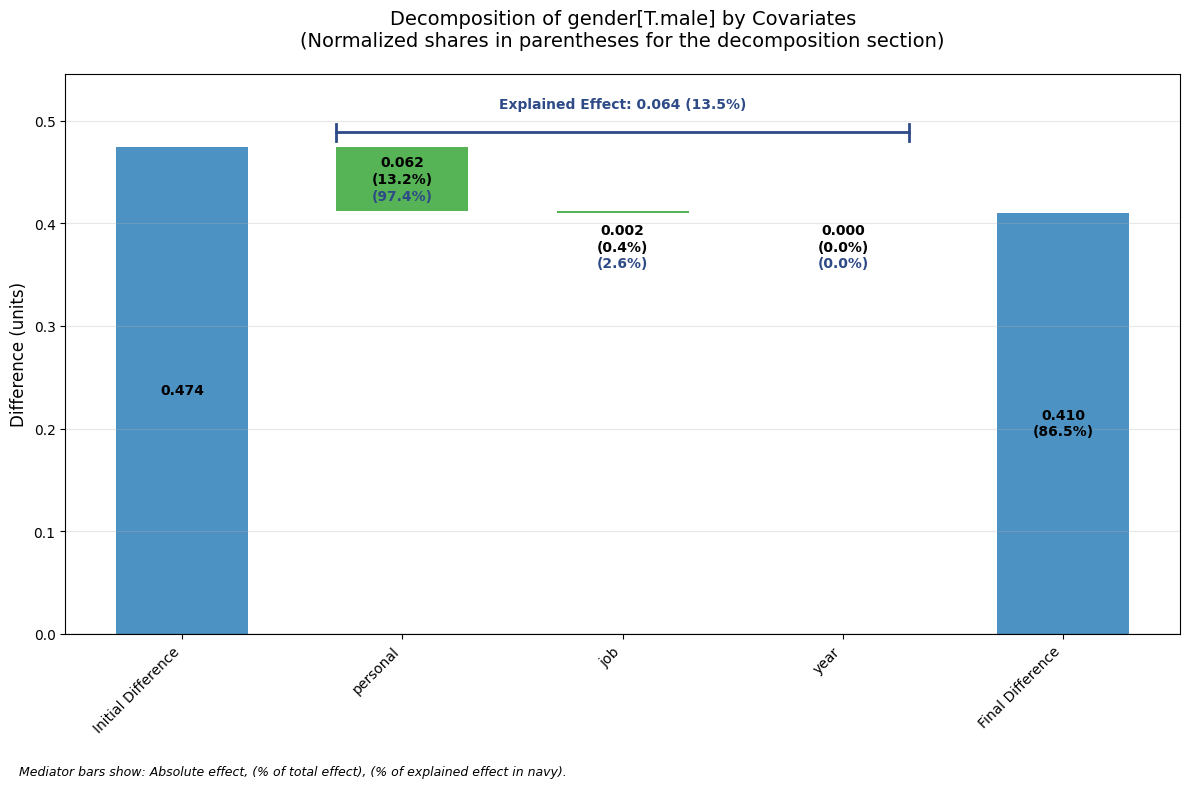

In [15]:
gb3.coefplot()

## Literature 

- ["When do Covariates Matter? And Which Ones, and How Much?" by Gelbach, Jonah B. (2016), Journal of Labor Economics](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1425737)